### Chain Using LangGraph
In this section we will see how we can build a simple chain using Langgraph that uses 4 important concepts

- How to use chat messages as our graph state
- How to use chat models in graph nodes
- How to bind tools to our LLM in chat models
- How to execute the tools call in our graph nodes 

In [41]:
from dotenv import load_dotenv
load_dotenv()

True

In [42]:
import os 

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

#### How to use chat messages as our graph state
##### Messages

We can use messages which can be used to capture different roles within a conversation.
LangChain has various message types including HumanMessage, AIMessage, SystemMessage and ToolMessage.
These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call.

Every message have these important components.

- content - content of the message
- name - Specify the name of author
- response_metadata - optionally, a dict of metadata (e.g., often populated by model provider for AIMessages)



In [43]:
from langchain_core.messages import AIMessage, HumanMessage
from pprint import pprint

messages = [AIMessage(content = f"Please tell me How can I help you?", name = "LLM_Model")]
messages.append(HumanMessage(content = f"I want to learn Coding.", name = "Om"))
messages.append(AIMessage(content = f"What do you want to learn.", name = "LLM_Model"))

for message in messages:
    message.pretty_print()

================================== Ai Message ==================================
Name: LLM_Model

Please tell me How can I help you?
================================ Human Message =================================
Name: Om

I want to learn Coding.
================================== Ai Message ==================================
Name: LLM_Model

What do you want to learn.


### Chat Models

We can use the sequence of message as input with the chatmodels using LLM's and OPENAI.

In [44]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="qwen/qwen3-32b")
result=llm.invoke(messages)

In [45]:
result.response_metadata

{'token_usage': {'completion_tokens': 1582,
  'prompt_tokens': 50,
  'total_tokens': 1632,
  'completion_time': 5.1049813,
  'prompt_time': 0.001849921,
  'queue_time': 0.052648439,
  'total_time': 5.106831221},
 'model_name': 'qwen/qwen3-32b',
 'system_fingerprint': 'fp_5cf921caa2',
 'service_tier': 'on_demand',
 'finish_reason': 'stop',
 'logprobs': None,
 'model_provider': 'groq'}

### Tools
Tools can be integrated with the LLM models to interact with external systems. External systems can be API's, third party tools.

Whenever a query is asked the model can choose to call the tool and this query is based on the 
natural language input and this will return an output that matches the tool's schema

In [46]:
def add(a:int, b:int) -> int:
    """ Add a and b
    Args:
        a (int): first int
        b (int): second int

    Returns:
        int
    """
    return a + b

In [47]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000233E3455DF0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000233E33C2C60>, model_name='qwen/qwen3-32b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [48]:
## Binding the tool with  LLM

llm_with_tool = llm.bind_tools([add])

llm_with_tool.invoke([HumanMessage(content=f"What is 2 plus 2", name = "Krish")])

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking "What is 2 plus 2?" Let me see. I need to figure out which function to use here. The available tool is the \'add\' function, which takes two integers, a and b. The question is straightforward addition, so the add function is exactly what\'s needed. The parameters required are a and b, both integers. Here, 2 and 2 are the numbers to add. So I should call the add function with a=2 and b=2. There\'s no ambiguity here, so no need to ask for more information. Just generate the tool call with those values.\n', 'tool_calls': [{'id': 'xrpfh5m9d', 'function': {'arguments': '{"a":2,"b":2}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 158, 'prompt_tokens': 181, 'total_tokens': 339, 'completion_time': 0.283172553, 'prompt_time': 0.008164866, 'queue_time': 0.410508559, 'total_time': 0.291337419, 'completion_tokens_details': {'reasoning_tokens': 129}}, 'model_nam

In [49]:
response = llm_with_tool.invoke([HumanMessage(content=f"What is 2 plus 2", name = "Krish")])

In [50]:
response.additional_kwargs

{'reasoning_content': 'Okay, the user is asking "What is 2 plus 2". I need to figure out how to respond. Let me check the tools provided. There\'s a function called add that takes two integers, a and b. The description says it adds them together. So, for 2 plus 2, I can use this add function. The parameters required are a and b, both integers. I should call the function with a=2 and b=2. Then, the function should return the result, which is 4. I need to make sure I format the tool call correctly in JSON inside the XML tags. Let me double-check the syntax. The name should be "add" and the arguments are a JSON object with a and b as 2. Yep, that looks right. No other tools are available, so this is the correct approach.\n',
 'tool_calls': [{'id': '4e137jkp3',
   'function': {'arguments': '{"a":2,"b":2}', 'name': 'add'},
   'type': 'function'}]}

In [51]:
response.tool_calls

[{'name': 'add',
  'args': {'a': 2, 'b': 2},
  'id': '4e137jkp3',
  'type': 'tool_call'}]

In [52]:
response.response_metadata

{'token_usage': {'completion_tokens': 204,
  'prompt_tokens': 181,
  'total_tokens': 385,
  'completion_time': 0.427705202,
  'prompt_time': 0.007309556,
  'queue_time': 0.053178704,
  'total_time': 0.435014758,
  'completion_tokens_details': {'reasoning_tokens': 175}},
 'model_name': 'qwen/qwen3-32b',
 'system_fingerprint': 'fp_5cf921caa2',
 'service_tier': 'on_demand',
 'finish_reason': 'tool_calls',
 'logprobs': None,
 'model_provider': 'groq'}

## Using Messages as State

In [53]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

#### Reducers
Now, we have a minor problem!

As we discussed, each node will return a new value for our state key messages.

But, this new value will override the prior messages value.

As our graph runs, we want to append messages to our messages state key.

We can use reducer functions to address this.

Reducers allow us to specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should override it as we saw before.

But, to append messages, we can use the pre-built add_messages reducer.

This ensures that any messages are appended to the existing list of messages.

We simply need to annotate our messages key with the add_messages reducer function as metadata.

In [54]:
from langgraph.graph.message import add_messages
from typing import Annotated

class State(TypedDict):
    messages:Annotated[list[AnyMessage], add_messages]

### Reducers with add_messages

In [55]:
initial_messages=[AIMessage(content=f"Please tell me how can I help",name="LLMModel")]
initial_messages.append(HumanMessage(content=f"I want to learn coding",name="Krish"))
initial_messages

[AIMessage(content='Please tell me how can I help', additional_kwargs={}, response_metadata={}, name='LLMModel'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Krish')]

In [56]:
ai_message=AIMessage(content=f"Which programming language you want to learn",name="LLMModel")
ai_message

AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='LLMModel')

In [57]:
### Reducers add_messages is to append instead of override
add_messages(initial_messages,ai_message)

[AIMessage(content='Please tell me how can I help', additional_kwargs={}, response_metadata={}, name='LLMModel', id='ba0bb77a-2188-4b97-9d7e-7cbb519be493'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Krish', id='c3ef7def-9702-4ad0-8192-3a19aaa6ee22'),
 AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='LLMModel', id='81bd889a-2bd0-437f-867b-76653a775b5e')]

In [58]:
## chatbot node functionality
def llm_tool(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

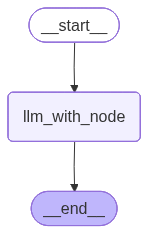

In [59]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

builder = StateGraph(State)

builder.add_node("llm_with_node", llm_tool)

builder.add_edge(START, "llm_with_node")
builder.add_edge("llm_with_node", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [60]:
## Invocation

messages = graph.invoke({"messages":"What is 2 plus 2?"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is 2 plus 2?
================================== Ai Message ==================================
Tool Calls:
  add (99rw7qe9x)
 Call ID: 99rw7qe9x
  Args:
    a: 2
    b: 2


In [61]:
tools = [add]

In [62]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


builder=StateGraph(State)

## Add nodes

builder.add_node("llm_tool",llm_tool)
builder.add_node("tools",ToolNode(tools))

## Add Edge
builder.add_edge(START,"llm_tool")
builder.add_conditional_edges(
    "llm_tool",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools",END)


graph_builder = builder.compile()



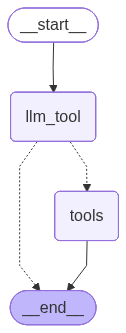

In [63]:
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [66]:
## Invocation

messages = graph_builder.invoke({"messages":"What is 2 plus 2?"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is 2 plus 2?
================================== Ai Message ==================================
Tool Calls:
  add (hpbeb93xs)
 Call ID: hpbeb93xs
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: add

4


In [67]:
## Invocation

messages = graph_builder.invoke({"messages":"What is Machine Learning?"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is Machine Learning?
================================== Ai Message ==================================

Machine Learning is a subset of artificial intelligence (AI) that focuses on building systems that can learn patterns and make decisions from data without being explicitly programmed for specific tasks. It uses algorithms to analyze input data, identify patterns, and make predictions or decisions based on that analysis. For example, it can classify emails as spam or not spam, recognize objects in images, or recommend products based on user behavior. Key types include:

1. **Supervised Learning**: Uses labeled data to train models (e.g., predicting house prices based on features like size and location).
2. **Unsupervised Learning**: Finds hidden patterns in unlabeled data (e.g., grouping customers by purchasing behavior).
3. **Reinforcement Learning**: Learns by interacting with an environment to max